## 🧭 Workflow for Urban Morphology and Street Connectivity Analysis Dashboard
Integrated Workflow for Urban Morphology & Connectivity Analysis
Using a custom boundary loaded from file.

Requirements:
  - osmnx, geopandas, momepy, shapely, matplotlib, contextily, dash, dash_table, plotly, scipy

This script:
  1. Loads a custom boundary from a file (e.g., GeoJSON).
  2. Reprojects the boundary to WGS84 (EPSG:4326) for OSMnx extraction.
  3. Extracts building footprints and the street network using OSMnx.
  4. Reprojects the data into an appropriate UTM CRS.
  5. Cleans and rounds building geometries to reduce precision issues.
  6. Pre-processes buildings to mitigate overlapping features.
  7. Computes building‑level morphological metrics.
  8. Generates urban blocks via tessellation and performs block‑level analysis.
  9. Computes street orientation entropy and connectivity metrics.
 1.  Exports block‑level results as a GeoPackage.
 2.  Sets up an interactive Dash dashboard.

### STEP 0: 📦 Import required packages

In [1]:
import osmnx as ox
import geopandas as gpd
import momepy
import numpy as np
import matplotlib.pyplot as plt
import contextily as cx
from pyproj import CRS
from shapely.ops import transform
from shapely.validation import make_valid
from scipy.stats import entropy
import dash
from dash import dcc, html, dash_table
import plotly.express as px
import pandas as pd

### Step 1: Load Custom Boundary

In [2]:
# Load your custom boundary file (e.g., GeoJSON, Shapefile, etc.)
boundary = gpd.read_file("map/tuyhoa-map.geojson")  
# Force the boundary to be in WGS84 (EPSG:4326) because OSMnx requires geographic coordinates.
boundary = boundary.to_crs("EPSG:4326")
# Optionally, dissolve multiple features into one (if your file has more than one polygon)
boundary = boundary.dissolve()

### Step 2: Download Data Using OSMnx

In [ ]:
# Use the boundary polygon (in EPSG:4326) to extract building footprints.
buildings = ox.features_from_polygon(boundary.unary_union, tags={"building": True})
# Filter only polygons/multipolygons.
buildings = buildings[buildings.geometry.type.isin(["Polygon", "MultiPolygon"])].copy().reset_index(drop=True)
buildings["uid"] = buildings.index
# For further analysis, retain only the necessary columns
buildings = buildings[["uid", "geometry"]].copy()

# Extract street network (driving network) using the same boundary.
G = ox.graph_from_polygon(boundary.unary_union, network_type="drive")
edges = ox.graph_to_gdfs(G, nodes=False, edges=True)

### Step 3: Project and Clean Geometries

In [ ]:
# For building-level analysis, we need to work in a projected CRS.
# First, compute an appropriate UTM CRS from the buildings (currently in WGS84)
def get_utm_crs(gdf):
    centroid = gdf.geometry.unary_union.centroid
    lon, lat = centroid.x, centroid.y
    utm_zone = int((lon + 180) / 6) + 1
    return CRS.from_dict({"proj": "utm", "zone": utm_zone, "south": lat < 0})

utm_crs = get_utm_crs(buildings)
buildings = buildings.to_crs(utm_crs)
edges = edges.to_crs(utm_crs)
crs = utm_crs  # save for later use

# Helper: clean and round geometries to reduce precision issues.
def clean_and_round_geometry(geom, precision=0):
    if not geom.is_valid:
        try:
            geom = make_valid(geom)
        except Exception:
            geom = geom.buffer(0)
    def rounder(x, y, z=None):
        if z is None:
            return (round(x, precision), round(y, precision))
        else:
            return (round(x, precision), round(y, precision), round(z, precision))
    return transform(rounder, geom)

buildings["geometry"] = buildings.geometry.apply(lambda g: clean_and_round_geometry(g, precision=0))
buildings = buildings[buildings.geometry.is_valid & (~buildings.geometry.is_empty)].copy()

### Step 4: Pre-process Buildings


In [5]:
# Simplify and buffer building geometries to mitigate overlapping and narrow connection issues.
buildings["geometry"] = buildings.geometry.simplify(0.5)  # simplify with 0.5 m tolerance
buildings["geometry"] = buildings.geometry.buffer(-0.5).buffer(0.5)  # apply slight negative then positive buffer

### Step 5: Compute Building-Level Morphological Metrics

In [6]:
# Recalculate the area and convex hull area after simplification and buffering.
buildings["area"] = buildings.geometry.area
buildings["convex_hull_area"] = buildings.geometry.convex_hull.area
buildings["compactness"] = buildings["area"] / buildings["convex_hull_area"]

def calc_elongation(geom):
    try:
        rect = geom.minimum_rotated_rectangle
        coords = list(rect.exterior.coords)
        lengths = [np.hypot(coords[i+1][0]-coords[i][0], coords[i+1][1]-coords[i][1])
                   for i in range(len(coords)-1)]
        if len(lengths) < 2 or min(lengths) == 0:
            return np.nan
        return max(lengths) / min(lengths)
    except Exception:
        return np.nan

buildings["elongation"] = buildings.geometry.apply(calc_elongation)

### Step 6: Block-Level Analysis via Tessellation


In [7]:
# Here we use momepy.enclosed_tessellation which tends to handle overlapping features more robustly.
tessellation = momepy.morphological_tessellation(buildings.geometry, shrink=0.1, segment=1.0)
tessellation = tessellation.reset_index(drop=True)
tessellation["block_id"] = tessellation.index

print("Tessellation complete. Here are the first few blocks:")
print(tessellation.head())

Tessellation complete. Here are the first few blocks:
                                            geometry  block_id
0  POLYGON ((315058.518 1449657.378, 314632.558 1...         0
1  POLYGON ((316931.169 1449243.444, 316930.886 1...         1
2  POLYGON ((316840.373 1447728.785, 316836.147 1...         2
3  POLYGON ((316775.411 1447482.817, 316774.161 1...         3
4  POLYGON ((316550.72 1447159.919, 316541.854 14...         4


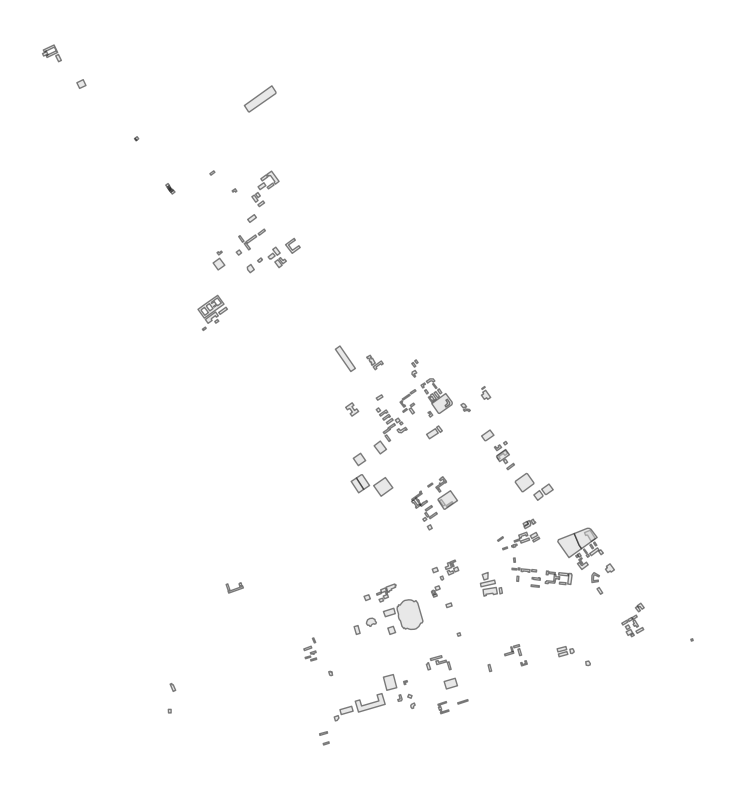

In [8]:
ax = buildings.plot(figsize=(10, 10), color="lightgray", edgecolor="black", alpha=0.5)
ax.set_axis_off()

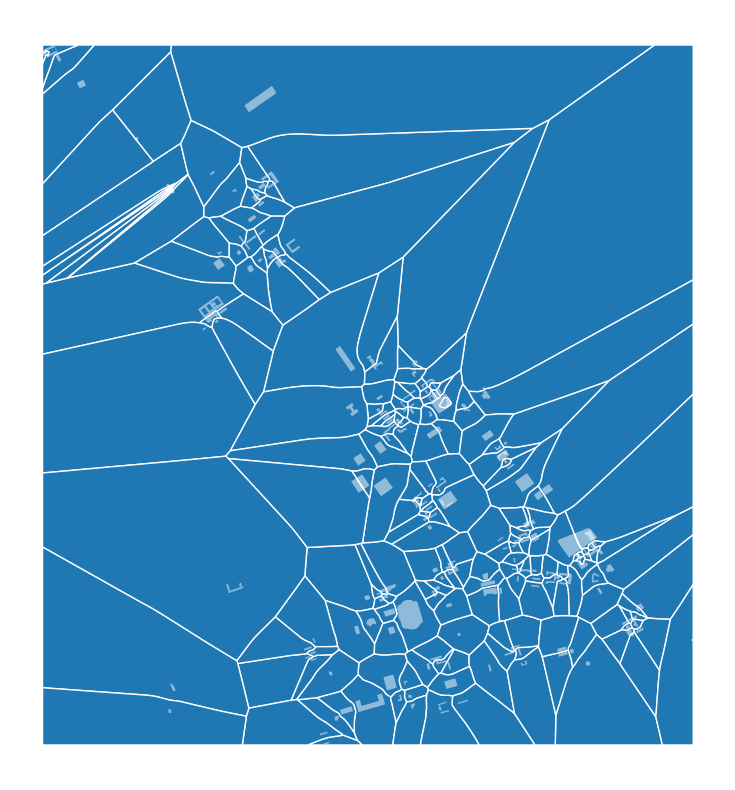

In [9]:
ax = tessellation.plot(edgecolor="white", figsize=(10, 10))
buildings.plot(ax=ax, color="white", alpha=0.5)
ax.set_axis_off()

In [12]:
# Perform the spatial join: assign each building to the block it falls within.
joined = gpd.sjoin(buildings, tessellation, predicate="within", how="left")

# Reset the index to ensure a flat DataFrame.
joined = joined.reset_index(drop=True)

# Explicitly create a one-dimensional 'block_id' column from the spatial join result.
# The spatial join produces a column 'index_right'; we copy its values into 'block_id' as a plain array.
joined["block_id"] = np.array(joined["index_right"])
joined = joined.drop(columns=["index_right"])

# Verify that 'block_id' is one-dimensional.
print("Unique block IDs:", joined["block_id"].unique())

Unique block IDs: [  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15. 209.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.
  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.
  41.  42.  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.
  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.
  69.  70.  71.  72.  73.  74.  75.  76.  77.  78.  79.  nan  82.  83.
 219.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.
  97.  98.  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110.
 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.
 125. 126. 127. 128. 129. 130. 131. 132. 134. 135. 136. 137. 138. 139.
 140. 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153.
 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167.
 168. 169. 170. 171. 172. 173. 174. 175. 176. 202. 177. 178. 179. 180.
 181. 182. 185. 186. 187. 188. 189. 190. 191. 192. 195. 196

In [13]:
# Compute block-level metrics:
# a) Average building area per block and building count.
block_stats = joined.groupby("block_id").agg(
    avg_bldg_area=("geometry", lambda geoms: np.mean([g.area for g in geoms])),
    bldg_count=("geometry", "count")
).reset_index()

In [14]:
# Merge the computed block_stats with the tessellation GeoDataFrame.
tessellation = tessellation.reset_index(drop=True)
tessellation = tessellation.merge(block_stats, on="block_id", how="left")

# Compute additional block metrics.
tessellation["block_area"] = tessellation.geometry.area
tessellation["area_ha"] = tessellation["block_area"] / 10000  # convert m² to hectares
tessellation["bldg_density"] = tessellation["bldg_count"] / tessellation["area_ha"]

# Compute average elongation and compactness per block.
block_morph = joined.groupby("block_id").agg(
    avg_elongation=("elongation", "mean"),
    avg_compactness=("compactness", "mean")
).reset_index()
tessellation = tessellation.merge(block_morph, on="block_id", how="left")

# Compute block shape factor: (4π * area) / (perimeter^2)
tessellation["perimeter"] = tessellation.geometry.length
tessellation["shape_factor"] = (4 * np.pi * tessellation["block_area"]) / (tessellation["perimeter"] ** 2)

# Display a preview
print(tessellation.head())

                                            geometry  block_id  avg_bldg_area  \
0  POLYGON ((315058.518 1449657.378, 314632.558 1...         0    6631.639760   
1  POLYGON ((316931.169 1449243.444, 316930.886 1...         1     986.739985   
2  POLYGON ((316840.373 1447728.785, 316836.147 1...         2   21552.757324   
3  POLYGON ((316775.411 1447482.817, 316774.161 1...         3    5276.784133   
4  POLYGON ((316550.72 1447159.919, 316541.854 14...         4    7631.675931   

   bldg_count     block_area    area_ha  bldg_density  avg_elongation  \
0         1.0  417085.153659  41.708515      0.023976        2.212859   
1         1.0    4462.135183   0.446214      2.241080        1.189104   
2         1.0   74732.428287   7.473243      0.133811        1.352940   
3         1.0   53275.680971   5.327568      0.187703        1.329688   
4         1.0   93829.066818   9.382907      0.106577        2.449287   

   avg_compactness    perimeter  shape_factor  
0         0.667181  3037.6

In [15]:
tessellation.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   geometry         224 non-null    geometry
 1   block_id         224 non-null    int64   
 2   avg_bldg_area    211 non-null    float64 
 3   bldg_count       211 non-null    float64 
 4   block_area       224 non-null    float64 
 5   area_ha          224 non-null    float64 
 6   bldg_density     211 non-null    float64 
 7   avg_elongation   211 non-null    float64 
 8   avg_compactness  211 non-null    float64 
 9   perimeter        224 non-null    float64 
 10  shape_factor     224 non-null    float64 
dtypes: float64(9), geometry(1), int64(1)
memory usage: 19.4 KB


### Export block-level analysis results to a GeoPackage.


In [16]:
export_path = "results/tuyhoa_block_analysis.gpkg"
tessellation.to_file(export_path, layer="block_morphology", driver="GPKG")
print(f"Block-level analysis exported to {export_path}")

Block-level analysis exported to results/tuyhoa_block_analysis.gpkg


### Step 7: Street Orientation & Connectivity Analysis


In [17]:
# Define Helper Functions
def calculate_orientation(geom):
    """
    Compute the orientation (in degrees, normalized to 0-180) for a LineString.
    """
    if geom.geom_type == "LineString":
        x_diff = geom.coords[-1][0] - geom.coords[0][0]
        y_diff = geom.coords[-1][1] - geom.coords[0][1]
        angle = np.arctan2(y_diff, x_diff)
        return np.degrees(angle) % 180
    return np.nan

In [18]:
# Calculate orientation for each street segment.
edges["orientation"] = edges.geometry.apply(calculate_orientation)
num_bins = 36
bin_edges = np.linspace(0, 180, num_bins+1)
orientation_hist, _ = np.histogram(edges["orientation"].dropna(), bins=bin_edges)
orientation_prob = orientation_hist / orientation_hist.sum()
street_entropy = entropy(orientation_prob, base=2)
print(f"Street orientation entropy: {street_entropy:.3f} (0 = perfect grid; higher = more irregular)")


Street orientation entropy: 4.356 (0 = perfect grid; higher = more irregular)


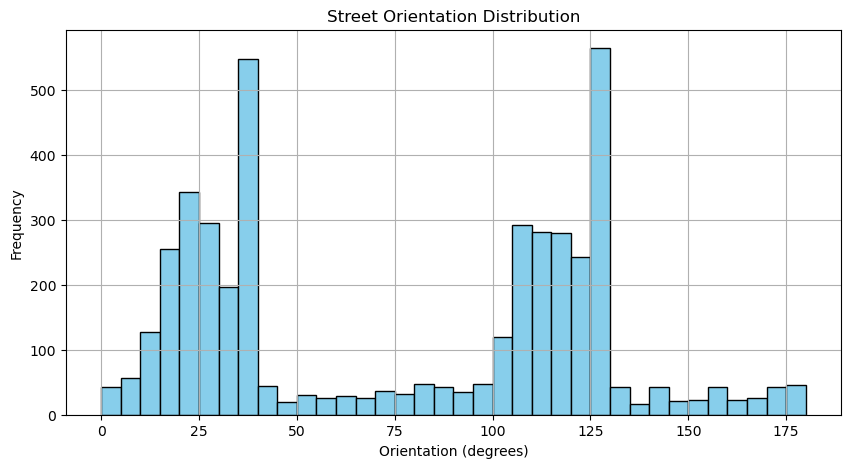

In [19]:
# Optional: Plot the orientation distribution.
plt.figure(figsize=(10, 5))
plt.hist(edges["orientation"].dropna(), bins=bin_edges, color="skyblue", edgecolor="black")
plt.title("Street Orientation Distribution")
plt.xlabel("Orientation (degrees)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [20]:
# Compute street connectivity metrics.
nodes, _ = ox.graph_to_gdfs(G)
nodes = nodes.to_crs(crs)
nodes["degree"] = [G.degree(n) for n in nodes.index]
intersection_nodes = nodes[nodes["degree"] > 2]
# Estimate study area from building union.
study_area = gpd.GeoSeries([buildings.unary_union], crs=crs)
study_area_km2 = study_area.area.iloc[0] / 1e6
intersection_density = len(intersection_nodes) / study_area_km2
avg_node_degree = np.mean([G.degree(n) for n in nodes.index])
print(f"Intersection Density: {intersection_density:.2f} intersections/km²")
print(f"Average Node Degree: {avg_node_degree:.2f}")

Intersection Density: 5197.08 intersections/km²
Average Node Degree: 5.11


C:\Users\thienle\AppData\Local\Temp\ipykernel_18460\2066421452.py:7: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  study_area = gpd.GeoSeries([buildings.unary_union], crs=crs)


In [21]:
connectivity_metrics = [
    {"Metric": "Intersection Density (intersections/km²)", "Value": round(intersection_density, 2)},
    {"Metric": "Average Node Degree", "Value": round(avg_node_degree, 2)}
]

# Prepare GeoJSON for tessellation (for Plotly)
tessellation_json = tessellation.__geo_interface__

### Step 7: Dashboard with Dash

In [27]:
# ---------------------------
# Prepare GeoJSON for tessellation.
tessellation_json = tessellation.__geo_interface__

# Create choropleth map of block-level metrics (shape factor)
metrics_fig = px.choropleth_mapbox(
    tessellation,
    geojson=tessellation_json,
    locations="block_id",
    color="shape_factor",
    hover_data=["avg_bldg_area", "bldg_density", "avg_compactness", "avg_elongation"],
    color_continuous_scale="Viridis",
    mapbox_style="carto-positron",
    zoom=12,
    center={"lat": buildings.geometry.centroid.y.mean(), "lon": buildings.geometry.centroid.x.mean()},
    opacity=0.7,
    labels={"shape_factor": "Shape Factor"}
)

# Create an additional map showing the urban blocks boundaries.
# Here, we use a uniform color and display the block outlines.
blocks_fig = px.choropleth_mapbox(
    tessellation,
    geojson=tessellation_json,
    locations="block_id",
    color="block_id",  # Color by block_id so that each block gets a different (but arbitrary) color
    color_continuous_scale=px.colors.sequential.Greys,
    mapbox_style="carto-positron",
    zoom=12,
    center={"lat": buildings.geometry.centroid.y.mean(), "lon": buildings.geometry.centroid.x.mean()},
    opacity=0.4,  # more transparent so the basemap is visible
)
# Remove colorbar from the blocks map (since color isn't a meaningful metric here)
blocks_fig.update_coloraxes(showscale=False)
# Update trace marker lines for block outlines:
blocks_fig.update_traces(marker_line_width=1, marker_line_color="black", showlegend=False)

# Create Dash App and layout.
app = dash.Dash(__name__)

app.layout = html.Div([
    html.H1("Phu Quoc Urban Morphology & Connectivity Dashboard", style={'textAlign': 'center'}),

    # Left column: Two maps (Metrics and Blocks) stacked vertically.
    html.Div([
        html.H2("Block-Level Metrics (Shape Factor)"),
        dcc.Graph(id="metrics-map", figure=metrics_fig),
        html.H2("Urban Blocks Map"),
        dcc.Graph(id="blocks-map", figure=blocks_fig)
    ], style={'width': '70%', 'display': 'inline-block', 'padding': '0 20px'}),

    # Right column: Connectivity metrics table.
    html.Div([
        html.H2("Street Connectivity Metrics"),
        dash_table.DataTable(
            id="connectivity-table",
            columns=[{"name": i, "id": i} for i in ["Metric", "Value"]],
            data=connectivity_metrics,
            style_cell={'textAlign': 'left', 'padding': '5px'},
            style_header={'backgroundColor': '#f9f9f9', 'fontWeight': 'bold'},
        )
    ], style={'width': '28%', 'display': 'inline-block', 'verticalAlign': 'top'}),

    # Dashboard explanation.
    html.Div([
        dcc.Markdown("""
        **Dashboard Explanation:**
        
        - The **Block-Level Metrics** map displays the block shape factor (with hover data for average building area, building density, average compactness, and elongation).
        - The **Urban Blocks Map** shows the block boundaries (with each block outlined and colored arbitrarily).
        - The **Connectivity Table** summarizes street network metrics:
            - **Intersection Density:** intersections per km².
            - **Average Node Degree:** average connectivity across nodes.
        - Street orientation entropy is printed in the console.
        """)
    ], style={'marginTop': 20, 'padding': '10px'})
])

if __name__ == '__main__':
    app.run_server(debug=True)

Run the script in your Python environment. The Dash dashboard will start a local web server (by default on http://127.0.0.1:8050) so you can interact with the data.